## 0. Goal
Given spectrograms of entire syllables, chop systematically to get spec windows, apply the trained VAE model to get latents of all spec windows. <br>
This notebook focused on call analysis. <br>
Differ from v2: use VAE model that's trained on calls only

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from skimage import transform
import gc

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdID = 'pair5RigCCU29'
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [1.5,7]
# what syllable to analyze
syl = ['v']
# what spectogram datasets to use
spec_suffix = 'Spectrogram1'
spec_run = 'spec_goffinet_traj_256_236'
# what VAE run to use
vae_suffix = 'VAE2'
vae_run = 'traj_chop_32_1_32'
fd_vae = os.path.join(fd_data, birdID, 'Traj', vae_suffix, vae_run)
# shape of the spectrogram window
X_SHAPE = (128, 128)

In [5]:
# define parameters for spectrograms
X_SHAPE = [128, 128]
p = {
    'get_spec': vae_goffinet.get_specZZ, # spectrogram maker
    'max_dur': 1e9, # maximum syllable duration
    'min_freq': 250, # minimum frequency
    'max_freq': 7500, # maximum frequency, default 7500
    'num_freq_bins': X_SHAPE[0], # hard-coded
    'num_time_bins': X_SHAPE[1], # hard-coded
    'nperseg': 256, # FFT
    'noverlap': 236, # FFT, determines window overlap when calculating spectrograms
    'spec_min_val': clims[0], # minimum log-spectrogram value
    'spec_max_val': clims[1], # maximum log-spectrogram value
    'fs': 20000, # audio samplerate
    'mel': False, # frequency spacing, mel or linear
    'time_stretch': False, # stretch short syllables?
    'within_syll_normalize': False, # normalize spectrogram values on a # spectrogram-by-spectrogram basis
    'pad': 0.05,  # when extracting syllables for calculating spectrograms, pad before syllable onset and after syllable onset, unit is sec
    'win_frame': 32,  # duration of the sliding window, unit is spectrogram column
    'hop_frame': 1, # how much to slide for consecutive window, unit is spectrogram column
    'win_pad': 32, # how much to include before syllable onset, unit is spectrogram column, default to one sliding window
}

In [6]:
# where to save VAE results
apply_suffix = 'applySyl3_1'
apply_run = f'latent.{vae_run}'
print(apply_run)

latent.traj_chop_32_1_32


## 2. Get the call subtype data

In [7]:
# load information of the syllable spectrograms
fn_spec = os.path.join(fd_data, birdID, 'Traj', spec_suffix, f'{birdID}.{spec_run}.h5')
fn_spec_info = os.path.join(fd_data, birdID, 'Traj', spec_suffix, f'{birdID}.{spec_run}.info.csv')
info_spec = pd.read_csv(fn_spec_info, index_col=0)
print(info_spec.shape)
info_spec.head()

(84254, 12)


,fn_wav,s_idx,istart,iend,label,spec_f,spec_t,i_start,i_end,zero_start,zero_end,rel_ori
0,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,0,660,3400,x,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,0,4400,340,0,1000
1,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,1,5740,12940,b,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,4740,13940,0,0,1000
2,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,2,18800,20000,x,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,17800,20860,0,140,1000
3,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,3,20860,24800,v,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,20000,25800,140,0,1000
4,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,4,28880,38480,b,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,27880,39480,0,0,1000


In [8]:
# load the call subtype data, use the latest
subtype_suffix = 'UMAPonVAE7'
subtype_run = 'spec_goffinet_nn_256_176'
fd_subtype = os.path.join(fd_data, birdID, subtype_suffix, 'v', subtype_run)
fn_subtype = os.path.join(fd_subtype, f'{birdID}.{subtype_run}.embedding.csv')
subtype = pd.read_csv(fn_subtype)
print(subtype.shape)

(23240, 44)


In [9]:
# merge the two dataframes based on fn_wav, s_idx and istart
info_merged = info_spec.merge(
    subtype[['fn_wav', 's_idx', 'istart', 'hdbscan_cluster', 'hdbscan_prob']],
    on=['fn_wav', 's_idx', 'istart'], how='left')
print(info_merged.shape)
info_merged.head()

(84254, 14)


,fn_wav,s_idx,istart,iend,label,spec_f,spec_t,i_start,i_end,zero_start,zero_end,rel_ori,hdbscan_cluster,hdbscan_prob
0,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,0,660,3400,x,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,0,4400,340,0,1000,NaN,NaN
1,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,1,5740,12940,b,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,4740,13940,0,0,1000,NaN,NaN
2,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,2,18800,20000,x,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,17800,20860,0,140,1000,NaN,NaN
3,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,3,20860,24800,v,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,20000,25800,140,0,1000,6.0,0.954308
4,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,4,28880,38480,b,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,27880,39480,0,0,1000,NaN,NaN


In [10]:
temp = info_merged[info_merged['label']=='v']
# check if there is any calls with matched rows
print(np.where(np.isnan(temp['hdbscan_cluster'])))

(array([], dtype=int64),)


In [11]:
# add a subtype column 
info_merged['hdbscan_cluster'] = info_merged['hdbscan_cluster'].astype('Int64')
info_merged['call_subtype'] = [f'v{aa}' for aa in info_merged['hdbscan_cluster']]

In [12]:
info_merged.iloc[0:20,:]

,fn_wav,s_idx,istart,iend,label,spec_f,spec_t,i_start,i_end,zero_start,zero_end,rel_ori,hdbscan_cluster,hdbscan_prob,call_subtype
0,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,0,660,3400,x,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,0,4400,340,0,1000,<NA>,NaN,v<NA>
1,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,1,5740,12940,b,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,4740,13940,0,0,1000,<NA>,NaN,v<NA>
2,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,2,18800,20000,x,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,17800,20860,0,140,1000,<NA>,NaN,v<NA>
3,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,3,20860,24800,v,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,20000,25800,140,0,1000,6,0.954308,v6
4,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,4,28880,38480,b,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,27880,39480,0,0,1000,<NA>,NaN,v<NA>
5,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,5,42760,45060,e,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,41760,46060,0,0,1000,<NA>,NaN,v<NA>
6,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,6,46760,50759,v,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,45760,51759,0,0,1000,6,0.667034,v6
7,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,7,55640,57560,x,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,54640,58560,0,0,1000,<NA>,NaN,v<NA>
8,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,8,60900,70560,b,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,59900,71560,0,0,1000,<NA>,NaN,v<NA>
9,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,9,75540,76300,h,[ 250. 307.08661417 364.17322835 42...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,74540,77300,0,0,1000,<NA>,NaN,v<NA>


In [13]:
Counter(info_merged['call_subtype'])

Counter({'v<NA>': 61014,
         'v6': 6658,
         'v1': 3798,
         'v7': 3102,
         'v4': 2421,
         'v0': 2288,
         'v3': 1796,
         'v2': 1658,
         'v5': 1519})

In [14]:
# save the merged table
fd_save = os.path.join(fd_data, birdID, 'Traj', apply_suffix, apply_run)
if not os.path.exists(fd_save):
    os.makedirs(fd_save)
print(fd_save)
fn_merged = os.path.join(fd_save, f'{birdID}.info_merged.csv')
info_merged.to_csv(fn_merged)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySyl3_1/latent.traj_chop_32_1_32


## 3. Select syllables, slide into spectrogram windows, obtain VAE latent

In [15]:
# select what syllables to use
temp = info_merged[info_merged['label']=='v']
syl_select = [f'v{ii}' for ii in range(0, max(temp['hdbscan_cluster'])+1)]
print('Syllables to use:', syl_select)

Syllables to use: ['v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7']


In [16]:
# load the VAE model
fn_vae = os.path.join(fd_vae, f'{birdID}_checkpoint_final.tar')
print(fn_vae)
model = vae_goffinet.VAE(save_dir=fd_vae)
model.load_state(fn_vae)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/VAE2/traj_chop_32_1_32/pair5RigCCU29_checkpoint_final.tar


In [24]:
# loop through call subtypes, chop to spec windows, then obtain VAE latents
model.eval()
for vi in range(len(syl_select)):
    # vi = 1
    v = syl_select[vi]
    idx_v = info_merged[info_merged['call_subtype']==v].index

    # analyze in batches
    b_size = 48
    b_starts = list(range(0, len(idx_v), b_size))
    if b_starts[-1]!=len(idx_v):
        b_starts.append(len(idx_v))
    # loop through batches
    latent_all_m = np.empty((0, 32))
    latent_all_d = np.empty((0, 32))
    info_all = pd.DataFrame()
    for b_i in range(len(b_starts)-1):
    # for b_i in range(3):
        bs = b_starts[b_i]
        be = b_starts[b_i+1]
        # chop 
        with Parallel(n_jobs=48, verbose=5) as parallel:
            res = parallel(delayed(vae_goffinet.ZZ_slideSylWin_v1)(fn_spec, ri, p, resize=True) for ri in idx_v[bs:be])  

        # flatten the result
        temp = [aa[0] for aa in res]
        specs = [arr for sublist in temp if sublist for arr in sublist]
        spec_win_all = np.stack(specs, axis=0)
        df_list = [aa[1] for aa in res]
        info = pd.concat([df for df in df_list if not df.empty], ignore_index=True)
        print(spec_win_all.shape, info.shape)

        # convert to datasets
        X_tensor = torch.from_numpy(spec_win_all).float()
        dataset = TensorDataset(X_tensor)
        # Create DataLoader
        train_dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)  

        # loop through dataloader, obtain model latent space
        latent_m = np.zeros((info.shape[0], 32))
        latent_d = np.zeros((info.shape[0], 32))
        # recon = np.zeros((info.shape[0], X_SHAPE[0], X_SHAPE[1]))
        model.eval()
        count = 0
        for i, data in tqdm.tqdm(enumerate(train_dataloader)):
            data = data[0].to('cuda:0')
            with torch.no_grad():
                _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)
                a = mu.shape[0]
                latent_m[count:(count+a),:] = mu
                latent_d[count:(count+a),:] = d
                # recon[count:(count+a),:,:] = rec
                count += a

        # append results
        latent_all_m = np.vstack([latent_all_m, latent_m])
        latent_all_d = np.vstack([latent_all_d, latent_d])
        info_all = pd.concat([info_all, info], ignore_index=True)

    # save the latent representations
    fn_latentM = os.path.join(fd_save, f'latentM.{v}.csv')
    np.savetxt(fn_latentM, latent_all_m, delimiter=',')
    fn_latentD = os.path.join(fd_save, f'latentD.{v}.csv')
    np.savetxt(fn_latentD, latent_all_d, delimiter=',')
    fn_info = os.path.join(fd_save, f'info.{v}.csv')
    info_all.to_csv(fn_info)
    print(latent_all_m.shape)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    9.7s remaining:  2.4min
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:   10.2s remaining:   27.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:   10.5s remaining:   11.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:   10.9s remaining:    4.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:   11.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:   11.3s finished


(8297, 128, 128) (8297, 4)


0it [00:00, ?it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
130it [00:01, 121.74it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8409, 128, 128) (8409, 4)


123it [00:00, 154.38it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
132it [00:01, 126.86it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.8s remaining:    2.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(7981, 128, 128) (7981, 4)


123it [00:00, 152.37it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
125it [00:00, 125.41it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    8.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.8s finished


(8425, 128, 128) (8425, 4)


132it [00:01, 125.77it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8726, 128, 128) (8726, 4)


136it [00:00, 148.05it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
137it [00:01, 123.35it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8499, 128, 128) (8499, 4)


118it [00:00, 148.43it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
133it [00:01, 121.48it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8570, 128, 128) (8570, 4)


133it [00:00, 146.58it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
134it [00:01, 121.12it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8793, 128, 128) (8793, 4)


138it [00:01, 126.32it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8197, 128, 128) (8197, 4)


118it [00:00, 146.87it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
129it [00:01, 120.42it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(8758, 128, 128) (8758, 4)


121it [00:00, 149.31it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
137it [00:01, 125.98it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9158, 128, 128) (9158, 4)


135it [00:00, 150.25it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
144it [00:01, 126.12it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9003, 128, 128) (9003, 4)


135it [00:00, 147.77it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
141it [00:01, 122.75it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8914, 128, 128) (8914, 4)


137it [00:00, 146.39it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
140it [00:01, 123.87it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9148, 128, 128) (9148, 4)


132it [00:00, 144.89it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
143it [00:01, 121.26it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(9181, 128, 128) (9181, 4)


132it [00:00, 146.60it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
144it [00:01, 123.20it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(8604, 128, 128) (8604, 4)


121it [00:00, 148.51it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
135it [00:01, 124.77it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(9279, 128, 128) (9279, 4)


133it [00:00, 147.36it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
145it [00:01, 122.09it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9887, 128, 128) (9887, 4)


151it [00:01, 148.59it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
155it [00:01, 125.00it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9359, 128, 128) (9359, 4)


137it [00:00, 150.94it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
147it [00:01, 125.08it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    5.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(9027, 128, 128) (9027, 4)


133it [00:00, 147.84it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
142it [00:01, 113.45it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8680, 128, 128) (8680, 4)


135it [00:00, 149.34it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
136it [00:01, 121.19it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9153, 128, 128) (9153, 4)


133it [00:00, 149.13it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
144it [00:01, 119.75it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9092, 128, 128) (9092, 4)


133it [00:00, 147.43it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
143it [00:01, 121.27it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9486, 128, 128) (9486, 4)


139it [00:00, 149.03it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
149it [00:01, 123.40it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.4s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.9s finished


(8963, 128, 128) (8963, 4)


141it [00:01, 124.16it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.9s finished


(8722, 128, 128) (8722, 4)


137it [00:01, 128.56it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9659, 128, 128) (9659, 4)


149it [00:01, 148.08it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
151it [00:01, 124.11it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9465, 128, 128) (9465, 4)


135it [00:00, 148.43it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
148it [00:01, 122.74it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9636, 128, 128) (9636, 4)


135it [00:00, 148.43it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
151it [00:01, 122.76it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.8s remaining:    2.2s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.8s finished


(9101, 128, 128) (9101, 4)


137it [00:00, 149.68it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
143it [00:01, 122.71it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.9s finished


(8978, 128, 128) (8978, 4)


141it [00:01, 125.21it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9281, 128, 128) (9281, 4)


146it [00:01, 124.71it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(9337, 128, 128) (9337, 4)


146it [00:01, 124.54it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    5.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.9s finished


(8916, 128, 128) (8916, 4)


134it [00:00, 145.45it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
140it [00:01, 120.76it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9900, 128, 128) (9900, 4)


151it [00:01, 147.22it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
155it [00:01, 125.99it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9746, 128, 128) (9746, 4)


153it [00:01, 122.61it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    8.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9638, 128, 128) (9638, 4)


149it [00:01, 147.48it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
151it [00:01, 120.60it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.9s finished


(8986, 128, 128) (8986, 4)


136it [00:00, 149.03it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
141it [00:01, 121.32it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9659, 128, 128) (9659, 4)


151it [00:01, 124.47it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    5.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.8s remaining:    2.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.8s finished


(8362, 128, 128) (8362, 4)


117it [00:00, 146.54it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
131it [00:01, 119.88it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9490, 128, 128) (9490, 4)


149it [00:01, 123.14it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9570, 128, 128) (9570, 4)


149it [00:01, 146.44it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
150it [00:01, 120.87it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9908, 128, 128) (9908, 4)


153it [00:01, 149.30it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
155it [00:01, 124.54it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9790, 128, 128) (9790, 4)


151it [00:01, 150.84it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
153it [00:01, 123.48it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9616, 128, 128) (9616, 4)


149it [00:01, 147.30it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
151it [00:01, 121.13it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(9614, 128, 128) (9614, 4)


151it [00:01, 128.85it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9683, 128, 128) (9683, 4)


149it [00:01, 144.17it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
152it [00:01, 121.84it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   7 out of  32 | elapsed:    0.7s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  14 out of  32 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  21 out of  32 | elapsed:    1.1s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  28 out of  32 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  32 out of  32 | elapsed:    1.5s finished


(6545, 128, 128) (6545, 4)


101it [00:00, 145.57it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
103it [00:00, 113.43it/s]


(435191, 32)


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10263, 128, 128) (10263, 4)


147it [00:01, 150.08it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
161it [00:01, 123.89it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10382, 128, 128) (10382, 4)


163it [00:01, 129.29it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10353, 128, 128) (10353, 4)


153it [00:01, 149.05it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
162it [00:01, 123.86it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10272, 128, 128) (10272, 4)


153it [00:01, 150.38it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
161it [00:01, 126.00it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10093, 128, 128) (10093, 4)


158it [00:01, 127.31it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10155, 128, 128) (10155, 4)


159it [00:01, 129.85it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10087, 128, 128) (10087, 4)


151it [00:01, 149.56it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
158it [00:01, 124.43it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10268, 128, 128) (10268, 4)


161it [00:01, 128.07it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10440, 128, 128) (10440, 4)


153it [00:01, 149.66it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
164it [00:01, 126.24it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10444, 128, 128) (10444, 4)


151it [00:01, 148.64it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
164it [00:01, 123.66it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10049, 128, 128) (10049, 4)


158it [00:01, 128.35it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10140, 128, 128) (10140, 4)


159it [00:01, 125.33it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10442, 128, 128) (10442, 4)


155it [00:01, 152.46it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
164it [00:01, 128.02it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10205, 128, 128) (10205, 4)


160it [00:01, 128.44it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10466, 128, 128) (10466, 4)


164it [00:01, 126.76it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9940, 128, 128) (9940, 4)


156it [00:01, 125.23it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   11.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10373, 128, 128) (10373, 4)


163it [00:01, 123.38it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10114, 128, 128) (10114, 4)


153it [00:01, 149.89it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
159it [00:01, 125.79it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10301, 128, 128) (10301, 4)


149it [00:01, 147.29it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
161it [00:01, 123.27it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10230, 128, 128) (10230, 4)


160it [00:01, 124.88it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10244, 128, 128) (10244, 4)


161it [00:01, 125.69it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   11.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10282, 128, 128) (10282, 4)


161it [00:01, 126.30it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10392, 128, 128) (10392, 4)


151it [00:01, 150.93it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
163it [00:01, 126.62it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.2s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.6s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10532, 128, 128) (10532, 4)


165it [00:01, 125.62it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10465, 128, 128) (10465, 4)


151it [00:01, 148.57it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
164it [00:01, 125.01it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   11.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.4s remaining:    3.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    2.0s remaining:    2.2s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.6s remaining:    1.2s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    3.2s remaining:    0.4s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    3.5s finished


(10470, 128, 128) (10470, 4)


164it [00:01, 94.88it/s] 
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.9s remaining:   13.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.2s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10551, 128, 128) (10551, 4)


163it [00:01, 148.30it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
165it [00:01, 125.81it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10501, 128, 128) (10501, 4)


165it [00:01, 125.99it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10447, 128, 128) (10447, 4)


164it [00:01, 127.44it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10413, 128, 128) (10413, 4)


163it [00:01, 124.95it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10424, 128, 128) (10424, 4)


149it [00:01, 145.27it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
163it [00:01, 123.07it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   11.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10585, 128, 128) (10585, 4)


166it [00:01, 126.02it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10404, 128, 128) (10404, 4)


163it [00:01, 125.03it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10560, 128, 128) (10560, 4)


165it [00:01, 126.75it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10530, 128, 128) (10530, 4)


165it [00:01, 126.81it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10172, 128, 128) (10172, 4)


159it [00:01, 127.79it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10214, 128, 128) (10214, 4)


160it [00:01, 126.72it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(10078, 128, 128) (10078, 4)


151it [00:01, 146.88it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
158it [00:01, 121.90it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(10193, 128, 128) (10193, 4)


160it [00:01, 125.60it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10247, 128, 128) (10247, 4)


157it [00:01, 145.84it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
161it [00:01, 93.61it/s] 
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10120, 128, 128) (10120, 4)


159it [00:01, 125.99it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10199, 128, 128) (10199, 4)


160it [00:01, 125.14it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10032, 128, 128) (10032, 4)


153it [00:01, 149.59it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
157it [00:01, 123.52it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9998, 128, 128) (9998, 4)


157it [00:01, 125.08it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10137, 128, 128) (10137, 4)


159it [00:01, 125.35it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10296, 128, 128) (10296, 4)


161it [00:01, 123.81it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10515, 128, 128) (10515, 4)


165it [00:01, 126.44it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10445, 128, 128) (10445, 4)


164it [00:01, 126.83it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10496, 128, 128) (10496, 4)


164it [00:01, 125.56it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10564, 128, 128) (10564, 4)


166it [00:01, 128.90it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(10179, 128, 128) (10179, 4)


160it [00:01, 125.22it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10288, 128, 128) (10288, 4)


161it [00:01, 125.84it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10027, 128, 128) (10027, 4)


157it [00:01, 124.95it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10159, 128, 128) (10159, 4)


147it [00:01, 115.86it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
159it [00:01, 105.87it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10418, 128, 128) (10418, 4)


151it [00:01, 147.29it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
163it [00:01, 122.88it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10517, 128, 128) (10517, 4)


152it [00:01, 149.56it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
165it [00:01, 124.91it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   11.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10345, 128, 128) (10345, 4)


162it [00:01, 126.32it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10127, 128, 128) (10127, 4)


159it [00:01, 125.67it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10250, 128, 128) (10250, 4)


161it [00:01, 123.78it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10252, 128, 128) (10252, 4)


161it [00:01, 123.99it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10416, 128, 128) (10416, 4)


163it [00:01, 126.61it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10436, 128, 128) (10436, 4)


164it [00:01, 124.49it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   12.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10629, 128, 128) (10629, 4)


167it [00:01, 125.41it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10450, 128, 128) (10450, 4)


164it [00:01, 125.21it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10328, 128, 128) (10328, 4)


162it [00:01, 124.25it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10341, 128, 128) (10341, 4)


151it [00:01, 148.21it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
162it [00:01, 123.65it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10180, 128, 128) (10180, 4)


160it [00:01, 124.81it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9801, 128, 128) (9801, 4)


151it [00:01, 146.07it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
154it [00:01, 121.78it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9793, 128, 128) (9793, 4)


154it [00:01, 124.67it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9966, 128, 128) (9966, 4)


151it [00:01, 148.93it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
156it [00:01, 124.22it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9891, 128, 128) (9891, 4)


151it [00:01, 149.60it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
155it [00:01, 125.42it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9963, 128, 128) (9963, 4)


156it [00:01, 125.93it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10188, 128, 128) (10188, 4)


160it [00:01, 124.96it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9814, 128, 128) (9814, 4)


154it [00:01, 123.34it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(9679, 128, 128) (9679, 4)


152it [00:01, 123.92it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10071, 128, 128) (10071, 4)


158it [00:01, 124.60it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10342, 128, 128) (10342, 4)


162it [00:01, 126.16it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10243, 128, 128) (10243, 4)


161it [00:01, 124.98it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10018, 128, 128) (10018, 4)


157it [00:01, 125.24it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=48)]: Done   6 out of   6 | elapsed:    0.5s finished


(1256, 128, 128) (1256, 4)


20it [00:00, 63.22it/s] 


(811890, 32)


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8690, 128, 128) (8690, 4)


136it [00:01, 119.06it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9017, 128, 128) (9017, 4)


141it [00:01, 123.30it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9039, 128, 128) (9039, 4)


142it [00:01, 124.54it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8967, 128, 128) (8967, 4)


141it [00:01, 91.92it/s] 
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   11.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(8749, 128, 128) (8749, 4)


137it [00:01, 124.64it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8935, 128, 128) (8935, 4)


140it [00:01, 122.38it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8835, 128, 128) (8835, 4)


139it [00:01, 124.65it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8782, 128, 128) (8782, 4)


138it [00:01, 121.18it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9129, 128, 128) (9129, 4)


143it [00:01, 124.57it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8951, 128, 128) (8951, 4)


140it [00:01, 122.16it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8814, 128, 128) (8814, 4)


138it [00:01, 119.58it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8635, 128, 128) (8635, 4)


135it [00:01, 123.01it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8851, 128, 128) (8851, 4)


139it [00:01, 126.54it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8829, 128, 128) (8829, 4)


138it [00:01, 123.34it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8618, 128, 128) (8618, 4)


135it [00:01, 123.45it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8540, 128, 128) (8540, 4)


134it [00:01, 121.59it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8619, 128, 128) (8619, 4)


135it [00:01, 120.74it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(8988, 128, 128) (8988, 4)


141it [00:01, 122.68it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8758, 128, 128) (8758, 4)


137it [00:01, 123.36it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.8s remaining:    2.2s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.4s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.9s finished


(8472, 128, 128) (8472, 4)


133it [00:01, 122.13it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8617, 128, 128) (8617, 4)


135it [00:01, 122.17it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8655, 128, 128) (8655, 4)


136it [00:01, 119.38it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.8s remaining:    2.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.4s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.9s finished


(8722, 128, 128) (8722, 4)


137it [00:01, 123.30it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8837, 128, 128) (8837, 4)


139it [00:01, 121.57it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8842, 128, 128) (8842, 4)


139it [00:01, 122.03it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.9s finished


(8784, 128, 128) (8784, 4)


138it [00:01, 123.40it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.9s finished


(8754, 128, 128) (8754, 4)


137it [00:01, 119.87it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8662, 128, 128) (8662, 4)


136it [00:01, 123.37it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8824, 128, 128) (8824, 4)


138it [00:01, 122.98it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.9s finished


(8558, 128, 128) (8558, 4)


134it [00:01, 123.15it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.9s finished


(8658, 128, 128) (8658, 4)


136it [00:01, 122.46it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8748, 128, 128) (8748, 4)


137it [00:01, 122.81it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.9s finished


(8617, 128, 128) (8617, 4)


135it [00:01, 120.02it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8678, 128, 128) (8678, 4)


136it [00:01, 120.55it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  26 | elapsed:    0.5s remaining:    3.6s
[Parallel(n_jobs=48)]: Done   9 out of  26 | elapsed:    0.7s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  15 out of  26 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  21 out of  26 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  26 out of  26 | elapsed:    1.2s finished


(4685, 128, 128) (4685, 4)


74it [00:00, 104.10it/s]


(302859, 32)


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.6s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.5s finished


(6648, 128, 128) (6648, 4)


104it [00:00, 116.78it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6322, 128, 128) (6322, 4)


99it [00:00, 113.43it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.7s finished


(6189, 128, 128) (6189, 4)


97it [00:00, 112.75it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6120, 128, 128) (6120, 4)


96it [00:00, 115.89it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.5s finished


(6347, 128, 128) (6347, 4)


89it [00:00, 145.81it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
100it [00:00, 113.60it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    2.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.7s finished


(6533, 128, 128) (6533, 4)


103it [00:00, 115.19it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    5.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6513, 128, 128) (6513, 4)


102it [00:00, 116.23it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    2.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.7s finished


(6449, 128, 128) (6449, 4)


101it [00:00, 116.32it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    3.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6406, 128, 128) (6406, 4)


101it [00:00, 115.79it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    5.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.8s finished


(6793, 128, 128) (6793, 4)


107it [00:00, 116.36it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.8s remaining:    2.2s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.8s finished


(6718, 128, 128) (6718, 4)


105it [00:00, 116.67it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6474, 128, 128) (6474, 4)


102it [00:00, 117.31it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.8s finished


(6538, 128, 128) (6538, 4)


103it [00:00, 113.09it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6494, 128, 128) (6494, 4)


102it [00:00, 118.20it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6197, 128, 128) (6197, 4)


87it [00:00, 144.21it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
97it [00:00, 110.64it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    2.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.7s finished


(6590, 128, 128) (6590, 4)


103it [00:00, 118.06it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6209, 128, 128) (6209, 4)


98it [00:00, 117.11it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.7s finished


(6499, 128, 128) (6499, 4)


102it [00:00, 116.97it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.8s remaining:    2.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.7s finished


(6536, 128, 128) (6536, 4)


103it [00:00, 114.34it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.8s remaining:    2.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6074, 128, 128) (6074, 4)


95it [00:00, 112.37it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    2.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.7s finished


(6828, 128, 128) (6828, 4)


107it [00:00, 115.96it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6428, 128, 128) (6428, 4)


101it [00:00, 112.62it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.5s finished


(6120, 128, 128) (6120, 4)


96it [00:00, 115.00it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.7s finished


(6433, 128, 128) (6433, 4)


101it [00:00, 115.07it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6451, 128, 128) (6451, 4)


101it [00:00, 114.80it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6424, 128, 128) (6424, 4)


101it [00:00, 114.95it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.5s finished


(6422, 128, 128) (6422, 4)


101it [00:00, 114.17it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.6s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.5s finished


(6102, 128, 128) (6102, 4)


96it [00:00, 113.02it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    5.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.5s finished


(6055, 128, 128) (6055, 4)


95it [00:00, 114.57it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6322, 128, 128) (6322, 4)


99it [00:00, 113.78it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.6s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.5s finished


(6140, 128, 128) (6140, 4)


96it [00:00, 112.08it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.5s finished


(6154, 128, 128) (6154, 4)


97it [00:00, 117.32it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6250, 128, 128) (6250, 4)


98it [00:00, 115.03it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.4s finished


(5923, 128, 128) (5923, 4)


93it [00:00, 117.39it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    5.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.7s finished


(6050, 128, 128) (6050, 4)


95it [00:00, 113.48it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.6s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.5s finished


(6068, 128, 128) (6068, 4)


95it [00:00, 113.58it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    5.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.7s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished


(6516, 128, 128) (6516, 4)


102it [00:00, 116.80it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   5 out of  20 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  10 out of  20 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=48)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  20 out of  20 | elapsed:    0.7s finished


(2407, 128, 128) (2407, 4)


38it [00:00, 87.54it/s] 


(237742, 32)


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.0s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.7s finished


(10334, 128, 128) (10334, 4)


162it [00:01, 123.68it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9988, 128, 128) (9988, 4)


157it [00:01, 127.73it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9971, 128, 128) (9971, 4)


156it [00:01, 124.08it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.6s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10060, 128, 128) (10060, 4)


158it [00:01, 125.56it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10351, 128, 128) (10351, 4)


162it [00:01, 127.42it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.6s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.0s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(10078, 128, 128) (10078, 4)


158it [00:01, 127.46it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10232, 128, 128) (10232, 4)


160it [00:01, 125.58it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9991, 128, 128) (9991, 4)


157it [00:01, 125.32it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10139, 128, 128) (10139, 4)


149it [00:01, 147.52it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
159it [00:01, 123.39it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10049, 128, 128) (10049, 4)


158it [00:01, 127.51it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10200, 128, 128) (10200, 4)


160it [00:01, 124.51it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   12.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10301, 128, 128) (10301, 4)


161it [00:01, 125.60it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10137, 128, 128) (10137, 4)


159it [00:01, 126.68it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9938, 128, 128) (9938, 4)


156it [00:01, 124.39it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10218, 128, 128) (10218, 4)


160it [00:01, 125.38it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9979, 128, 128) (9979, 4)


156it [00:01, 126.15it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9969, 128, 128) (9969, 4)


156it [00:01, 124.58it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9958, 128, 128) (9958, 4)


156it [00:01, 127.92it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10143, 128, 128) (10143, 4)


159it [00:01, 129.13it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10225, 128, 128) (10225, 4)


160it [00:01, 125.81it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9954, 128, 128) (9954, 4)


156it [00:01, 123.07it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10233, 128, 128) (10233, 4)


160it [00:01, 126.40it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10273, 128, 128) (10273, 4)


161it [00:01, 124.59it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9936, 128, 128) (9936, 4)


156it [00:01, 124.24it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(9723, 128, 128) (9723, 4)


152it [00:01, 126.56it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9971, 128, 128) (9971, 4)


156it [00:01, 123.98it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9770, 128, 128) (9770, 4)


153it [00:01, 126.22it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9502, 128, 128) (9502, 4)


149it [00:01, 123.06it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9603, 128, 128) (9603, 4)


151it [00:01, 121.77it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9652, 128, 128) (9652, 4)


151it [00:01, 122.59it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9611, 128, 128) (9611, 4)


151it [00:01, 125.30it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   11.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9776, 128, 128) (9776, 4)


153it [00:01, 123.71it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9524, 128, 128) (9524, 4)


149it [00:01, 122.19it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9668, 128, 128) (9668, 4)


152it [00:01, 124.49it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9555, 128, 128) (9555, 4)


150it [00:01, 124.75it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9378, 128, 128) (9378, 4)


147it [00:01, 123.60it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9729, 128, 128) (9729, 4)


153it [00:01, 122.79it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9531, 128, 128) (9531, 4)


149it [00:01, 125.02it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9816, 128, 128) (9816, 4)


154it [00:01, 123.21it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9728, 128, 128) (9728, 4)


152it [00:01, 123.89it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9229, 128, 128) (9229, 4)


145it [00:01, 121.59it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9234, 128, 128) (9234, 4)


145it [00:01, 120.94it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(9421, 128, 128) (9421, 4)


148it [00:01, 122.06it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9405, 128, 128) (9405, 4)


147it [00:01, 123.10it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9581, 128, 128) (9581, 4)


150it [00:01, 125.83it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9468, 128, 128) (9468, 4)


148it [00:01, 125.07it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9449, 128, 128) (9449, 4)


148it [00:01, 125.94it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9433, 128, 128) (9433, 4)


148it [00:01, 125.04it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9298, 128, 128) (9298, 4)


146it [00:01, 122.00it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9013, 128, 128) (9013, 4)


141it [00:01, 124.89it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   6 out of  21 | elapsed:    0.6s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  11 out of  21 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  16 out of  21 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  21 out of  21 | elapsed:    1.1s finished


(4071, 128, 128) (4071, 4)


64it [00:00, 103.80it/s]


(494796, 32)


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(9806, 128, 128) (9806, 4)


154it [00:01, 124.39it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:    9.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10254, 128, 128) (10254, 4)


161it [00:01, 124.03it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10132, 128, 128) (10132, 4)


159it [00:01, 124.43it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10460, 128, 128) (10460, 4)


164it [00:01, 127.36it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10651, 128, 128) (10651, 4)


167it [00:01, 124.79it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.2s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.7s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.2s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.8s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    3.1s finished


(10312, 128, 128) (10312, 4)


162it [00:01, 126.46it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.8s remaining:    2.0s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.4s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    3.2s remaining:    0.4s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    3.5s finished


(10241, 128, 128) (10241, 4)


161it [00:01, 127.40it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.2s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.7s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.9s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    3.1s finished


(10461, 128, 128) (10461, 4)


164it [00:01, 126.82it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   11.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.4s remaining:    3.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.9s remaining:    2.1s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.4s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    3.0s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    3.3s finished


(10614, 128, 128) (10614, 4)


166it [00:01, 125.90it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   11.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.4s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    2.1s remaining:    2.2s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.7s remaining:    1.2s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    3.3s remaining:    0.4s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    3.6s finished


(10361, 128, 128) (10361, 4)


162it [00:01, 124.68it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10502, 128, 128) (10502, 4)


165it [00:01, 126.67it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    8.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10463, 128, 128) (10463, 4)


164it [00:01, 126.65it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10576, 128, 128) (10576, 4)


166it [00:01, 126.41it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10461, 128, 128) (10461, 4)


164it [00:01, 126.88it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10203, 128, 128) (10203, 4)


160it [00:01, 128.35it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9997, 128, 128) (9997, 4)


157it [00:01, 121.69it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(9547, 128, 128) (9547, 4)


150it [00:01, 122.36it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9711, 128, 128) (9711, 4)


152it [00:01, 122.51it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:    9.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9548, 128, 128) (9548, 4)


150it [00:01, 124.84it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9163, 128, 128) (9163, 4)


144it [00:01, 122.73it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9176, 128, 128) (9176, 4)


144it [00:01, 127.22it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9124, 128, 128) (9124, 4)


143it [00:01, 123.16it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9192, 128, 128) (9192, 4)


144it [00:01, 122.56it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9301, 128, 128) (9301, 4)


146it [00:01, 122.94it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9375, 128, 128) (9375, 4)


147it [00:01, 122.49it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9375, 128, 128) (9375, 4)


147it [00:01, 123.05it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9005, 128, 128) (9005, 4)


141it [00:01, 122.67it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8961, 128, 128) (8961, 4)


141it [00:01, 121.98it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8887, 128, 128) (8887, 4)


139it [00:01, 120.89it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(9151, 128, 128) (9151, 4)


143it [00:01, 120.75it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8799, 128, 128) (8799, 4)


138it [00:01, 125.26it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   6 out of  31 | elapsed:    0.6s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  13 out of  31 | elapsed:    0.9s remaining:    1.2s
[Parallel(n_jobs=48)]: Done  20 out of  31 | elapsed:    1.1s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  27 out of  31 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  31 out of  31 | elapsed:    1.5s finished


(5765, 128, 128) (5765, 4)


91it [00:00, 113.74it/s]


(309574, 32)


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.0s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.6s finished


(10847, 128, 128) (10847, 4)


170it [00:01, 125.45it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.0s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.7s finished


(11303, 128, 128) (11303, 4)


177it [00:01, 128.15it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:    9.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(11061, 128, 128) (11061, 4)


173it [00:01, 125.89it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(11336, 128, 128) (11336, 4)


178it [00:01, 125.80it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(10474, 128, 128) (10474, 4)


164it [00:01, 125.61it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(10798, 128, 128) (10798, 4)


169it [00:01, 125.76it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10607, 128, 128) (10607, 4)


166it [00:01, 124.54it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.6s finished


(10942, 128, 128) (10942, 4)


171it [00:01, 125.80it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.6s finished


(11295, 128, 128) (11295, 4)


177it [00:01, 128.72it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10761, 128, 128) (10761, 4)


169it [00:01, 125.69it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10584, 128, 128) (10584, 4)


166it [00:01, 126.52it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    5.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.6s finished


(10734, 128, 128) (10734, 4)


168it [00:01, 125.04it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.6s finished


(11024, 128, 128) (11024, 4)


173it [00:01, 127.63it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.7s finished


(11325, 128, 128) (11325, 4)


177it [00:01, 125.17it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(11011, 128, 128) (11011, 4)


173it [00:01, 125.50it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10779, 128, 128) (10779, 4)


169it [00:01, 124.78it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10383, 128, 128) (10383, 4)


163it [00:01, 122.94it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10870, 128, 128) (10870, 4)


170it [00:01, 126.15it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.2s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(10783, 128, 128) (10783, 4)


169it [00:01, 125.77it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10500, 128, 128) (10500, 4)


165it [00:01, 124.77it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10605, 128, 128) (10605, 4)


166it [00:01, 123.33it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10909, 128, 128) (10909, 4)


171it [00:01, 122.39it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   11.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10653, 128, 128) (10653, 4)


167it [00:01, 126.06it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10789, 128, 128) (10789, 4)


169it [00:01, 123.88it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10949, 128, 128) (10949, 4)


172it [00:01, 126.21it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.7s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.1s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.7s finished


(11439, 128, 128) (11439, 4)


179it [00:01, 125.60it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10531, 128, 128) (10531, 4)


165it [00:01, 128.44it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(10372, 128, 128) (10372, 4)


163it [00:01, 125.11it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10908, 128, 128) (10908, 4)


171it [00:01, 125.70it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10603, 128, 128) (10603, 4)


166it [00:01, 124.06it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10225, 128, 128) (10225, 4)


160it [00:01, 124.21it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10039, 128, 128) (10039, 4)


157it [00:01, 124.14it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.6s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(10423, 128, 128) (10423, 4)


163it [00:01, 124.22it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10123, 128, 128) (10123, 4)


159it [00:01, 124.50it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10577, 128, 128) (10577, 4)


166it [00:01, 122.73it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   11.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.6s finished


(10996, 128, 128) (10996, 4)


172it [00:01, 126.43it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10827, 128, 128) (10827, 4)


170it [00:01, 125.38it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:    9.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10445, 128, 128) (10445, 4)


164it [00:01, 124.30it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10836, 128, 128) (10836, 4)


170it [00:01, 124.32it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   11.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.0s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.6s finished


(11000, 128, 128) (11000, 4)


172it [00:01, 126.60it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(11128, 128, 128) (11128, 4)


174it [00:01, 124.92it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(11219, 128, 128) (11219, 4)


176it [00:01, 126.89it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10536, 128, 128) (10536, 4)


165it [00:01, 124.77it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9909, 128, 128) (9909, 4)


155it [00:01, 125.59it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10198, 128, 128) (10198, 4)


160it [00:01, 124.51it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10205, 128, 128) (10205, 4)


160it [00:01, 124.58it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:    9.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(10683, 128, 128) (10683, 4)


167it [00:01, 126.04it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10114, 128, 128) (10114, 4)


159it [00:01, 125.59it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   11.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10309, 128, 128) (10309, 4)


162it [00:01, 123.23it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.6s finished


(10905, 128, 128) (10905, 4)


171it [00:01, 124.67it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9910, 128, 128) (9910, 4)


155it [00:01, 124.38it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10716, 128, 128) (10716, 4)


168it [00:01, 122.48it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   11.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9886, 128, 128) (9886, 4)


155it [00:01, 123.47it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(9993, 128, 128) (9993, 4)


157it [00:01, 124.06it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10251, 128, 128) (10251, 4)


161it [00:01, 124.22it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10309, 128, 128) (10309, 4)


162it [00:01, 127.92it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    8.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9872, 128, 128) (9872, 4)


155it [00:01, 123.66it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(11010, 128, 128) (11010, 4)


173it [00:01, 123.63it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10855, 128, 128) (10855, 4)


170it [00:01, 126.24it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10573, 128, 128) (10573, 4)


166it [00:01, 124.81it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(10333, 128, 128) (10333, 4)


162it [00:01, 123.59it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10345, 128, 128) (10345, 4)


162it [00:01, 124.14it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10594, 128, 128) (10594, 4)


166it [00:01, 123.05it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10045, 128, 128) (10045, 4)


157it [00:01, 122.12it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9630, 128, 128) (9630, 4)


151it [00:01, 122.39it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9458, 128, 128) (9458, 4)


148it [00:01, 121.38it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   11.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(10760, 128, 128) (10760, 4)


169it [00:01, 125.56it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.6s finished


(10570, 128, 128) (10570, 4)


166it [00:01, 128.48it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10440, 128, 128) (10440, 4)


164it [00:01, 125.57it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   11.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10217, 128, 128) (10217, 4)


160it [00:01, 123.19it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10494, 128, 128) (10494, 4)


164it [00:01, 126.59it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.1s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10856, 128, 128) (10856, 4)


170it [00:01, 129.20it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:    9.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10986, 128, 128) (10986, 4)


172it [00:01, 124.90it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10187, 128, 128) (10187, 4)


160it [00:01, 125.83it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9999, 128, 128) (9999, 4)


157it [00:01, 93.55it/s] 
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   12.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9874, 128, 128) (9874, 4)


155it [00:01, 121.95it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9825, 128, 128) (9825, 4)


154it [00:01, 122.06it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9772, 128, 128) (9772, 4)


153it [00:01, 122.73it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9748, 128, 128) (9748, 4)


153it [00:01, 124.24it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(11108, 128, 128) (11108, 4)


174it [00:01, 127.07it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   11.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10339, 128, 128) (10339, 4)


162it [00:01, 122.95it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   11.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10245, 128, 128) (10245, 4)


161it [00:01, 93.97it/s] 
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.9s remaining:   13.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.2s remaining:    3.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.6s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.1s remaining:    1.0s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.6s finished


(10856, 128, 128) (10856, 4)


170it [00:01, 126.01it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10029, 128, 128) (10029, 4)


157it [00:01, 123.55it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(10576, 128, 128) (10576, 4)


166it [00:01, 124.07it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    8.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9589, 128, 128) (9589, 4)


150it [00:01, 124.11it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(9953, 128, 128) (9953, 4)


156it [00:01, 123.33it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:    9.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10148, 128, 128) (10148, 4)


159it [00:01, 124.35it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(9923, 128, 128) (9923, 4)


156it [00:01, 126.15it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9375, 128, 128) (9375, 4)


147it [00:01, 122.62it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9816, 128, 128) (9816, 4)


154it [00:01, 124.21it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10035, 128, 128) (10035, 4)


157it [00:01, 124.73it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9889, 128, 128) (9889, 4)


155it [00:01, 124.05it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10680, 128, 128) (10680, 4)


167it [00:01, 124.25it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9379, 128, 128) (9379, 4)


147it [00:01, 122.44it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9425, 128, 128) (9425, 4)


148it [00:01, 126.03it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(9551, 128, 128) (9551, 4)


150it [00:01, 122.29it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    5.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9460, 128, 128) (9460, 4)


148it [00:01, 121.56it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(9839, 128, 128) (9839, 4)


154it [00:01, 124.47it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(9807, 128, 128) (9807, 4)


154it [00:01, 124.39it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(9706, 128, 128) (9706, 4)


152it [00:01, 121.91it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.8s remaining:   11.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(9438, 128, 128) (9438, 4)


148it [00:01, 123.20it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(9795, 128, 128) (9795, 4)


154it [00:01, 124.46it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(9640, 128, 128) (9640, 4)


151it [00:01, 124.58it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(9296, 128, 128) (9296, 4)


146it [00:01, 121.25it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9363, 128, 128) (9363, 4)


147it [00:01, 121.64it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9486, 128, 128) (9486, 4)


149it [00:01, 120.40it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9483, 128, 128) (9483, 4)


149it [00:01, 122.68it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:    9.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(9804, 128, 128) (9804, 4)


154it [00:01, 125.03it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9562, 128, 128) (9562, 4)


150it [00:01, 125.05it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9980, 128, 128) (9980, 4)


156it [00:01, 125.45it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.5s finished


(10081, 128, 128) (10081, 4)


158it [00:01, 119.56it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9125, 128, 128) (9125, 4)


143it [00:01, 120.81it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9230, 128, 128) (9230, 4)


145it [00:01, 122.41it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9415, 128, 128) (9415, 4)


148it [00:01, 123.92it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9728, 128, 128) (9728, 4)


152it [00:01, 121.33it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9487, 128, 128) (9487, 4)


149it [00:01, 122.70it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:    9.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9362, 128, 128) (9362, 4)


147it [00:01, 122.61it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9965, 128, 128) (9965, 4)


156it [00:01, 122.89it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.6s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    2.0s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.6s finished


(10121, 128, 128) (10121, 4)


159it [00:01, 126.44it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10315, 128, 128) (10315, 4)


162it [00:01, 128.06it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10122, 128, 128) (10122, 4)


159it [00:01, 125.45it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(9334, 128, 128) (9334, 4)


146it [00:01, 122.44it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9953, 128, 128) (9953, 4)


156it [00:01, 124.02it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(9548, 128, 128) (9548, 4)


150it [00:01, 125.42it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9514, 128, 128) (9514, 4)


149it [00:01, 120.70it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9526, 128, 128) (9526, 4)


149it [00:01, 124.28it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:    9.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9318, 128, 128) (9318, 4)


146it [00:01, 122.29it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10174, 128, 128) (10174, 4)


159it [00:01, 122.69it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10132, 128, 128) (10132, 4)


159it [00:01, 126.54it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9527, 128, 128) (9527, 4)


149it [00:01, 122.52it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9969, 128, 128) (9969, 4)


156it [00:01, 123.00it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(10096, 128, 128) (10096, 4)


158it [00:01, 126.30it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10113, 128, 128) (10113, 4)


159it [00:01, 124.99it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.4s finished


(9606, 128, 128) (9606, 4)


151it [00:01, 121.76it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10132, 128, 128) (10132, 4)


159it [00:01, 126.42it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(10201, 128, 128) (10201, 4)


160it [00:01, 124.92it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(10291, 128, 128) (10291, 4)


161it [00:01, 124.48it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 out of  34 | elapsed:    0.3s remaining:    5.3s
[Parallel(n_jobs=48)]: Done   9 out of  34 | elapsed:    0.8s remaining:    2.1s
[Parallel(n_jobs=48)]: Done  16 out of  34 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  23 out of  34 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  30 out of  34 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  34 out of  34 | elapsed:    1.7s finished


(7510, 128, 128) (7510, 4)


118it [00:01, 117.76it/s]


(1420850, 32)


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8775, 128, 128) (8775, 4)


138it [00:01, 118.51it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.8s remaining:    2.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8673, 128, 128) (8673, 4)


136it [00:01, 121.01it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8495, 128, 128) (8495, 4)


133it [00:01, 118.52it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8435, 128, 128) (8435, 4)


132it [00:01, 122.32it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8545, 128, 128) (8545, 4)


134it [00:01, 119.11it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8432, 128, 128) (8432, 4)


132it [00:01, 120.96it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8651, 128, 128) (8651, 4)


136it [00:01, 122.27it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8586, 128, 128) (8586, 4)


135it [00:01, 121.03it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:    9.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9029, 128, 128) (9029, 4)


142it [00:01, 125.57it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8907, 128, 128) (8907, 4)


140it [00:01, 122.88it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(9000, 128, 128) (9000, 4)


141it [00:01, 92.34it/s] 
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8599, 128, 128) (8599, 4)


135it [00:01, 121.08it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8565, 128, 128) (8565, 4)


134it [00:01, 120.99it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    8.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8819, 128, 128) (8819, 4)


138it [00:01, 121.73it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8648, 128, 128) (8648, 4)


136it [00:01, 124.18it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:    9.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8604, 128, 128) (8604, 4)


135it [00:01, 118.95it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    8.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8920, 128, 128) (8920, 4)


140it [00:01, 121.75it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8677, 128, 128) (8677, 4)


136it [00:01, 122.45it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8935, 128, 128) (8935, 4)


140it [00:01, 123.03it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    3.0s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(8901, 128, 128) (8901, 4)


140it [00:01, 121.95it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8906, 128, 128) (8906, 4)


140it [00:01, 123.45it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8781, 128, 128) (8781, 4)


138it [00:01, 122.91it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8658, 128, 128) (8658, 4)


136it [00:01, 122.53it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8971, 128, 128) (8971, 4)


141it [00:01, 122.47it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    8.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8882, 128, 128) (8882, 4)


139it [00:01, 120.96it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(9241, 128, 128) (9241, 4)


145it [00:01, 125.59it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(8764, 128, 128) (8764, 4)


137it [00:01, 119.95it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8593, 128, 128) (8593, 4)


135it [00:01, 121.28it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8882, 128, 128) (8882, 4)


139it [00:01, 120.66it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8728, 128, 128) (8728, 4)


137it [00:01, 123.59it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8886, 128, 128) (8886, 4)


139it [00:01, 122.12it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8980, 128, 128) (8980, 4)


141it [00:01, 121.98it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8425, 128, 128) (8425, 4)


132it [00:01, 124.15it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8498, 128, 128) (8498, 4)


133it [00:01, 122.43it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8376, 128, 128) (8376, 4)


131it [00:01, 121.17it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8258, 128, 128) (8258, 4)


130it [00:01, 119.68it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    8.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8668, 128, 128) (8668, 4)


136it [00:01, 121.63it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8551, 128, 128) (8551, 4)


134it [00:01, 123.00it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8556, 128, 128) (8556, 4)


134it [00:01, 120.70it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    8.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8277, 128, 128) (8277, 4)


130it [00:01, 121.48it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8205, 128, 128) (8205, 4)


129it [00:01, 119.81it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.7s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8299, 128, 128) (8299, 4)


130it [00:01, 119.20it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(8765, 128, 128) (8765, 4)


137it [00:01, 121.06it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.5s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8039, 128, 128) (8039, 4)


126it [00:01, 118.91it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.4s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8179, 128, 128) (8179, 4)


128it [00:01, 117.80it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8251, 128, 128) (8251, 4)


129it [00:01, 120.71it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8266, 128, 128) (8266, 4)


130it [00:01, 121.24it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    8.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8597, 128, 128) (8597, 4)


135it [00:01, 118.82it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    5.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8336, 128, 128) (8336, 4)


131it [00:01, 120.71it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:    9.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8478, 128, 128) (8478, 4)


133it [00:01, 119.48it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.3s finished


(8632, 128, 128) (8632, 4)


135it [00:01, 120.36it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8542, 128, 128) (8542, 4)


134it [00:01, 123.68it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    8.6s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8434, 128, 128) (8434, 4)


132it [00:01, 118.92it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8352, 128, 128) (8352, 4)


131it [00:01, 123.58it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.4s remaining:    6.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8609, 128, 128) (8609, 4)


135it [00:01, 120.62it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8467, 128, 128) (8467, 4)


133it [00:01, 122.56it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.7s remaining:   10.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.1s remaining:    2.8s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8774, 128, 128) (8774, 4)


138it [00:01, 121.19it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    8.0s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8782, 128, 128) (8782, 4)


138it [00:01, 126.27it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    6.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.8s remaining:    2.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.0s finished


(8581, 128, 128) (8581, 4)


135it [00:01, 120.57it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.3s remaining:    4.8s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.8s remaining:    2.3s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.9s finished


(8395, 128, 128) (8395, 4)


132it [00:01, 121.31it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    8.2s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.2s finished


(8526, 128, 128) (8526, 4)


134it [00:01, 122.59it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.5s remaining:    7.9s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8777, 128, 128) (8777, 4)


138it [00:01, 121.08it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.3s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8785, 128, 128) (8785, 4)


138it [00:01, 120.67it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   3 out of  48 | elapsed:    0.6s remaining:    9.1s
[Parallel(n_jobs=48)]: Done  13 out of  48 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=48)]: Done  23 out of  48 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  33 out of  48 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  43 out of  48 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    2.1s finished


(8838, 128, 128) (8838, 4)


139it [00:01, 120.72it/s]
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   5 out of  30 | elapsed:    0.5s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  12 out of  30 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  19 out of  30 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  26 out of  30 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  30 out of  30 | elapsed:    1.3s finished


(5486, 128, 128) (5486, 4)


86it [00:00, 108.04it/s]


(557472, 32)


#### Check the sliding (optional)

In [17]:
ri = 16
# get the spectrogram dataset
with h5py.File(fn_spec, 'r') as f:
    # Access the dataset
    spec = f[f'spec_{ri}'][:] 

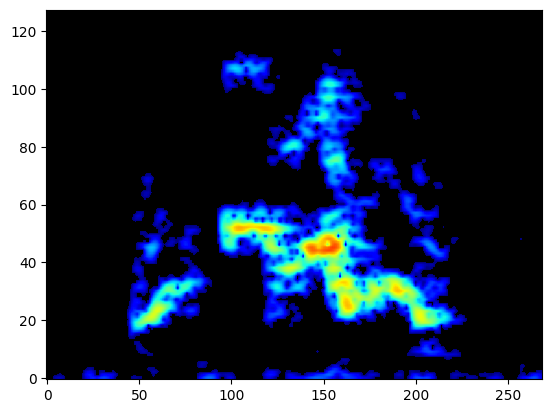

In [18]:
plt.imshow(spec, aspect='auto', cmap=custom_cmap, vmin=0, vmax=1, origin='lower')

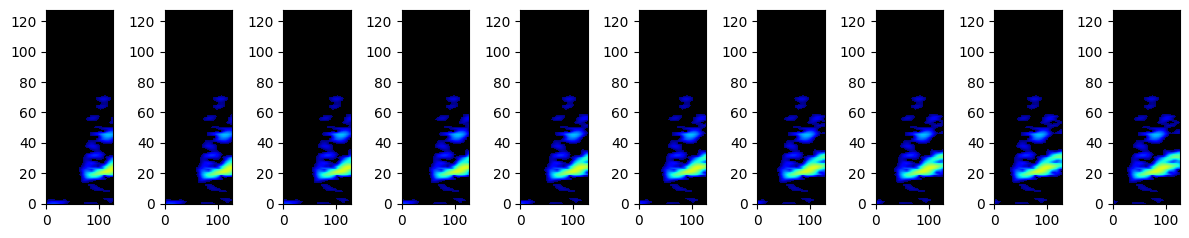

In [19]:
spec_wins, info_wins = vae_goffinet.ZZ_slideSylWin_v1(fn_spec, ri, p, resize=True) 
fig, axes = plt.subplots(1, 10, figsize=(12, 2.5))
start_i = 10
for ii in range(len(axes)):
    ax = axes[ii]
    ax.imshow(spec_wins[start_i+ii], aspect='auto', cmap=custom_cmap, vmin=0, vmax=1, origin='lower')
plt.tight_layout()
plt.show()

#### Check the reconstruction accuracy

In [20]:
spec_win_all = torch.tensor(np.stack(spec_wins, axis=0)).float()
spec_win_all.shape

torch.Size([201, 128, 128])

In [21]:
spec_win_all.dtype

torch.float32

In [22]:
data = spec_win_all.to('cuda:0')
with torch.no_grad():
    _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


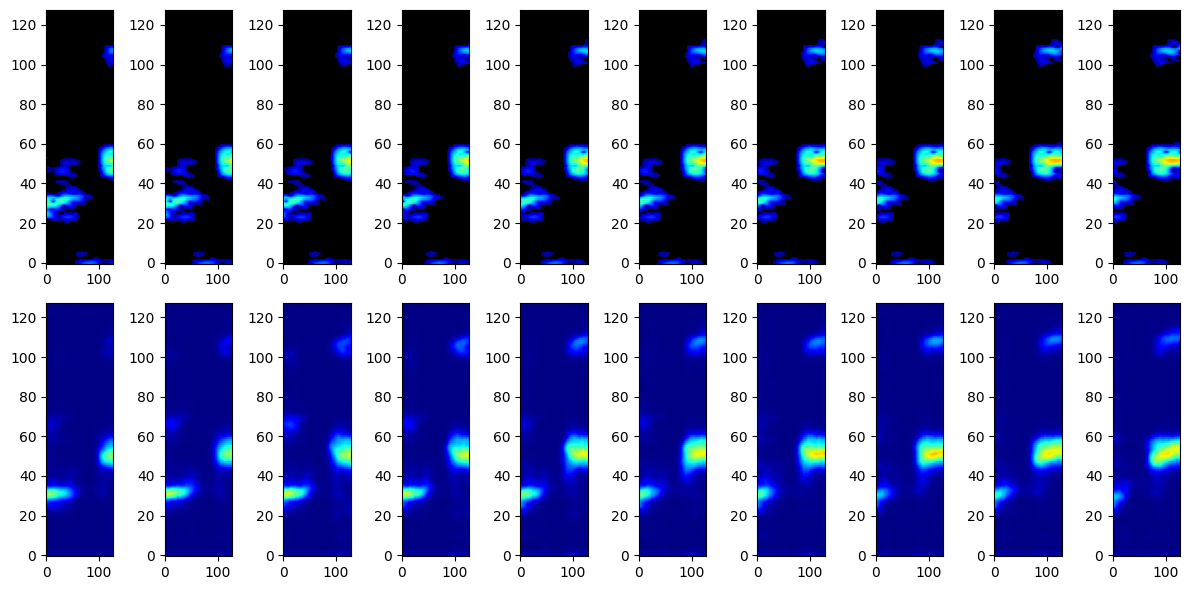

In [23]:
fig, axes = plt.subplots(2, 10, figsize=(12, 6))
start_i = 50
for ii in range(10):
    axes[0][ii].imshow(spec_wins[start_i+ii], aspect='auto', cmap=custom_cmap, vmin=0, vmax=1, origin='lower')
    axes[1][ii].imshow(rec[start_i+ii], aspect='auto', cmap=custom_cmap, vmin=0, vmax=1, origin='lower')
plt.tight_layout()
plt.show()

In [25]:
rec.shape

(201, 128, 128)